# Assignment 2
Discrete Cosine Transform

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy.linalg import toeplitz, circulant, dft
import io
import urllib.request

plt.rcParams.update({
    "font.serif":["cm"],
    "font.size": 12})

colors = {
    "blue": "#377eb8",
    "orange": "#ff7f00",
    "green": "#4daf4a",
    "pink": "#f781bf",
    "brown": "#a65628",
    "purple": "#984ea3",
    "gray": "#999999",
    "red": "#e41a1c",
    "yellow": "#dede00",
    "black": "#000000",
}

### Part 1: Plot 1D DCT basis function 

#### Part 1(a): Construct the basis 

In [3]:
def dct_matrix(N):
    """Create the DCT-II matrix of size N x N."""
    dct_mat = np.zeros((N, N))
    for k in range(N):
        for n in range(N):
            if k == 0:
                dct_mat[k, n] = 1 / np.sqrt(N)
            else:
                dct_mat[k, n] = np.sqrt(2 / N) * np.cos(np.pi * (2 * n + 1) * k / (2 * N))
    return dct_mat

D = dct_matrix(32)
print(r"Verifying orthogonality: ||D @ D.T - I||_F =", np.linalg.norm(D @ D.T - np.eye(32), 'fro'))

Verifying orthogonality: ||D @ D.T - I||_F = 1.8845225502080805e-14


#### Part 1(b): Visualize basis function

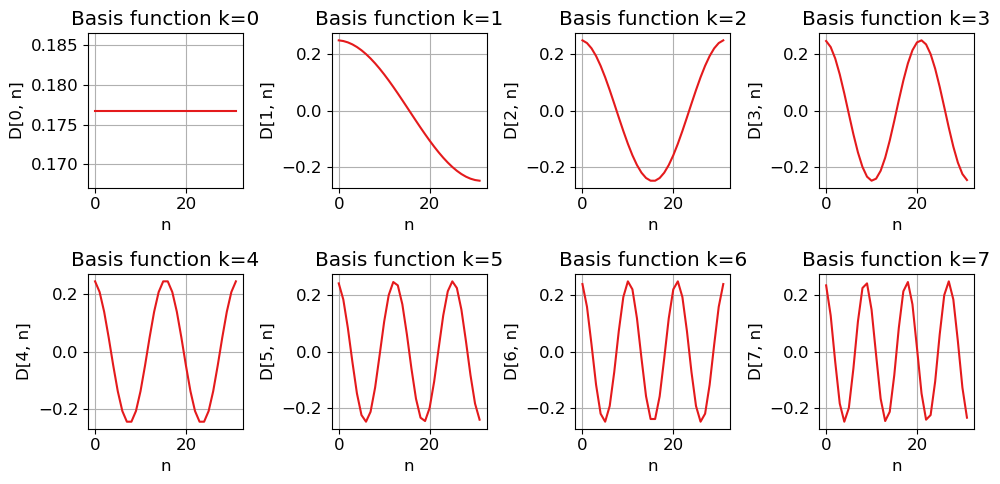

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for k in range(8):  
    n = np.arange(32)
    axs[k//4, k%4].plot(n, D[k, :], color=colors["red"])
    axs[k//4, k%4].set_title(f'Basis function k={k}')
    axs[k//4, k%4].set_xlabel('n')
    axs[k//4, k%4].set_ylabel(f'D[{k}, n]')
    axs[k//4, k%4].grid()
plt.tight_layout()
plt.show() 


### Part 2: Plot 2D DCT basis function 

#### Part 2(a): Separable 2D basis

In [5]:
# Separable 2D DCT basis functions using 1D DCT basis
def dct2d_basis(u, v, M=8, N=8):
    D_M = dct_matrix(M)
    D_N = dct_matrix(N)
    phi_u = D_M[u, :]  
    phi_v = D_N[v, :] 
    Phi_uv = np.outer(phi_u, phi_v)
    return Phi_uv

#### Part 2(b): Visualize the full 8*8 set

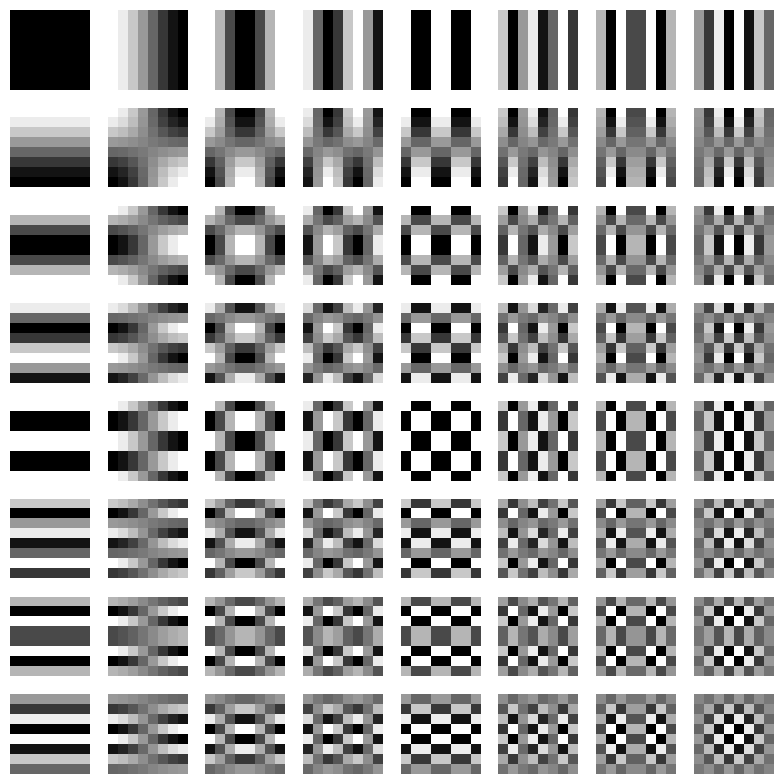

In [6]:
#visualize the 2D DCT basis functions 8*8 grid
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
for u in range(8):  
    for v in range(8):
        basis_2d = dct2d_basis(u, v, M=8, N=8)
        axs[u, v].imshow(basis_2d, cmap='gray', extent=(0, 7, 7, 0))
        axs[u, v].axis('off')
plt.tight_layout()
plt.show()

#### Part 2(c): 2D DCT on Image Blocks

In [7]:
def get_image():
    """Loads the image."""
    try:
        print(f"Loading test image from local file...")
        img = Image.open("test.png").convert('L')
        img = np.array(img).astype(float) / 255.0
        return img
    except Exception as e:
        print(f"Failed to load.")

In [8]:
# Apply 2D DCT to the image obtained from get_image()
image = get_image()
coefficients = np.zeros((8, 8))
for u in range(8):
    for v in range(8):
        basis_2d = dct2d_basis(u, v, M=image.shape[0], N=image.shape[1])
        coeff = np.sum(image * basis_2d)
        coefficients[u, v] = coeff
        

Loading test image from local file...


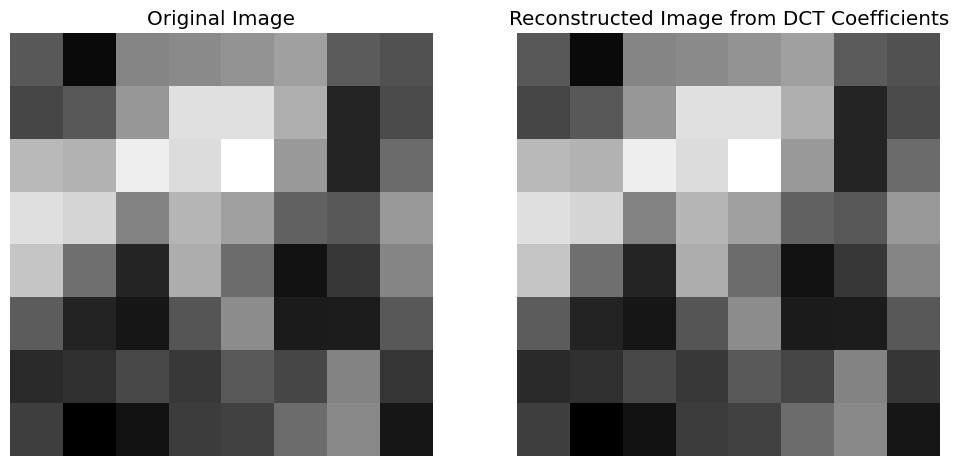

In [9]:
#Reconstruction of the image from DCT coefficients

reconstructed_image = np.zeros_like(image)
for u in range(8):
    for v in range(8):
        basis_2d = dct2d_basis(u, v, M=image.shape[0], N=image.shape[1])
        reconstructed_image += coefficients[u, v] * basis_2d    

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image from DCT Coefficients")
plt.axis('off')
plt.show()

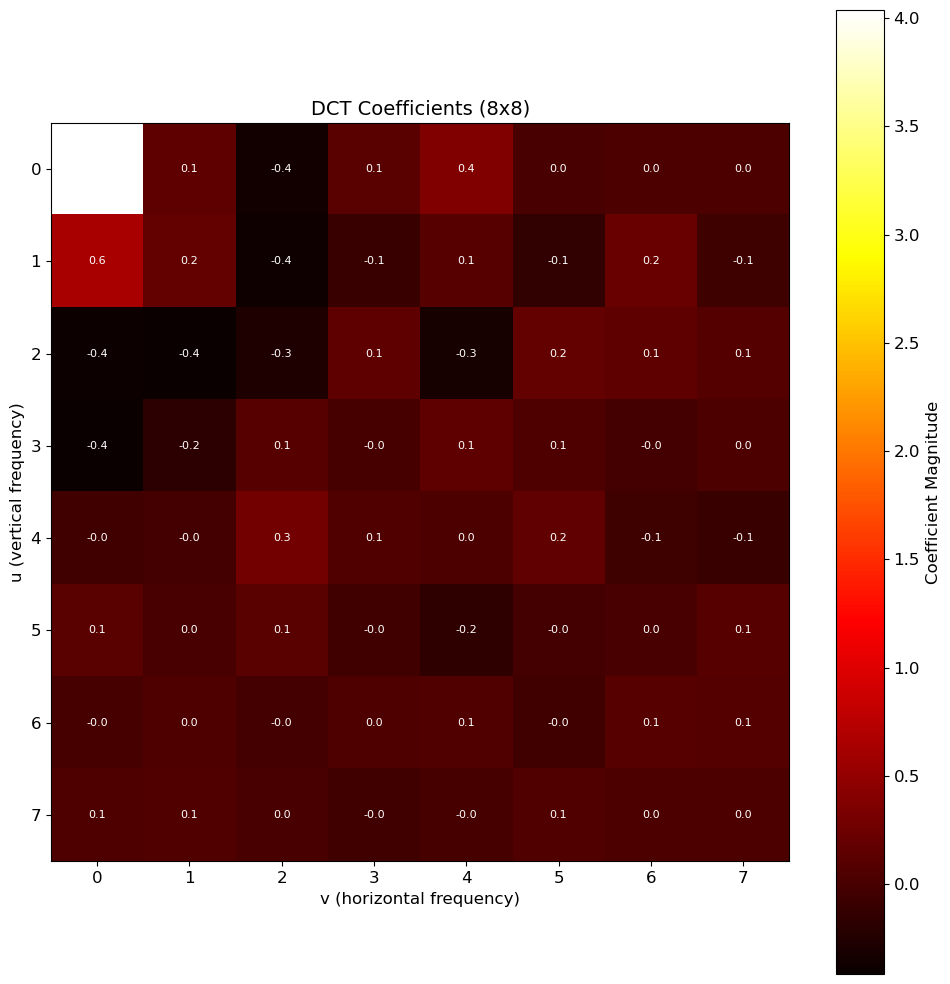

In [10]:
# Plot the DCT coefficients
plt.figure(figsize=(10, 10))
plt.imshow(coefficients, cmap='hot', interpolation='nearest')
plt.colorbar(label='Coefficient Magnitude')

for u in range(8):
    for v in range(8):
        plt.text(v, u, f'{coefficients[u, v]:.1f}', ha='center', va='center', color='white', fontsize=8)

plt.title('DCT Coefficients (8x8)', fontsize=14)
plt.xlabel('v (horizontal frequency)', fontsize=12)
plt.ylabel('u (vertical frequency)', fontsize=12)
plt.xticks(range(8))
plt.yticks(range(8))
plt.tight_layout()
plt.show()

### Part 3: Implement JPEG-style compression and investigate energy compaction 

#### Part 3(a): Block DCT and reconstruction

In [11]:
def get_image_sample():
    """Downloads 'baby.png' from Set5."""
    url = "https://raw.githubusercontent.com/jbhuang0604/SelfExSR/master/data/Set5/image_SRF_4/img_001_SRF_4_HR.png"
    try:
        print(f"Downloading Set5 image from {url}...")
        with urllib.request.urlopen(url) as response:
            data = response.read()
        img = Image.open(io.BytesIO(data)).convert('L') # Convert to Grayscale
        img = np.array(img).astype(float) / 255.0
        print("Download successful.")
        return img
    except Exception as e:
        print(f"Download failed ({e}). Generating synthetic text image...")

In [12]:
#Divide the image into 8x8 blocks and compute DCT for each block
baby_image = get_image_sample()
block_size = 8
height, width = baby_image.shape

D = dct_matrix(block_size)

dct_blocks = np.zeros((height // block_size, width // block_size, block_size, block_size))

for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        block = baby_image[i:i+block_size, j:j+block_size]
        dct_block = D @ block @ D.T
        dct_blocks[i // block_size, j // block_size] = dct_block

Download successful.


In [13]:
#Reconstruction of the image from the DCT coefficients of each block

reconstructed_baby_image = np.zeros_like(baby_image)
for i in range(dct_blocks.shape[0]):
    for j in range(dct_blocks.shape[1]):
        dct_block = dct_blocks[i, j]
        block = D.T @ dct_block @ D
        reconstructed_baby_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block

#Maximum absolute reconstruction error
max_error = np.max(np.abs(baby_image - reconstructed_baby_image))
print(f"Maximum absolute reconstruction error: {max_error}")


Maximum absolute reconstruction error: 5.329070518200751e-15


#### Part 3(b): Quantization 

Quantization Matrix Q:
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 2 2]
 [1 1 1 1 1 2 2 2]
 [1 1 1 1 2 2 2 2]
 [1 1 1 2 2 2 2 2]]


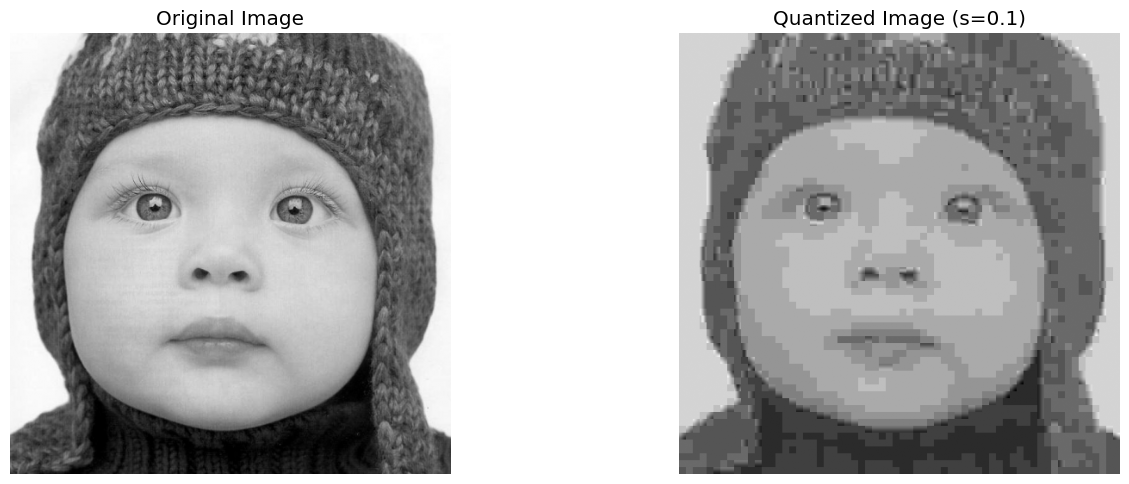


Compression Metrics (s=0.1):
MSE: 0.003595
PSNR: 24.44 dB


In [18]:
# Quantization parameter
s = 0.1

# Create quantization matrix Q[u,v] = 1 + s(u + v)
u, v = np.meshgrid(np.arange(0,block_size),np.arange(0,block_size))
Q = 1 + s*(u + v)

print("Quantization Matrix Q:")
print(Q.astype(int))

# Step 1: Quantize the DCT coefficients
quantized_dct_blocks = np.round(dct_blocks / Q)

# Step 2: Dequantize
dequantized_dct_blocks = quantized_dct_blocks * Q

# Step 3: Reconstruct the image using inverse DCT
reconstructed_quantized_image = np.zeros_like(baby_image)
for i in range(dct_blocks.shape[0]):
    for j in range(dct_blocks.shape[1]):
        dct_block = dequantized_dct_blocks[i, j]
        block = D.T @ dct_block @ D
        reconstructed_quantized_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block


# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(baby_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_quantized_image, cmap='gray')
plt.title(f"Quantized Image (s={s})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate metrics
mse = np.mean((baby_image - reconstructed_quantized_image)**2)
psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')
max_error = np.max(np.abs(baby_image - reconstructed_quantized_image))

print(f"\nCompression Metrics (s={s}):")
print(f"MSE: {mse:.6f}")
print(f"PSNR: {psnr:.2f} dB")

#### Part 3(d): Quality vs compression study

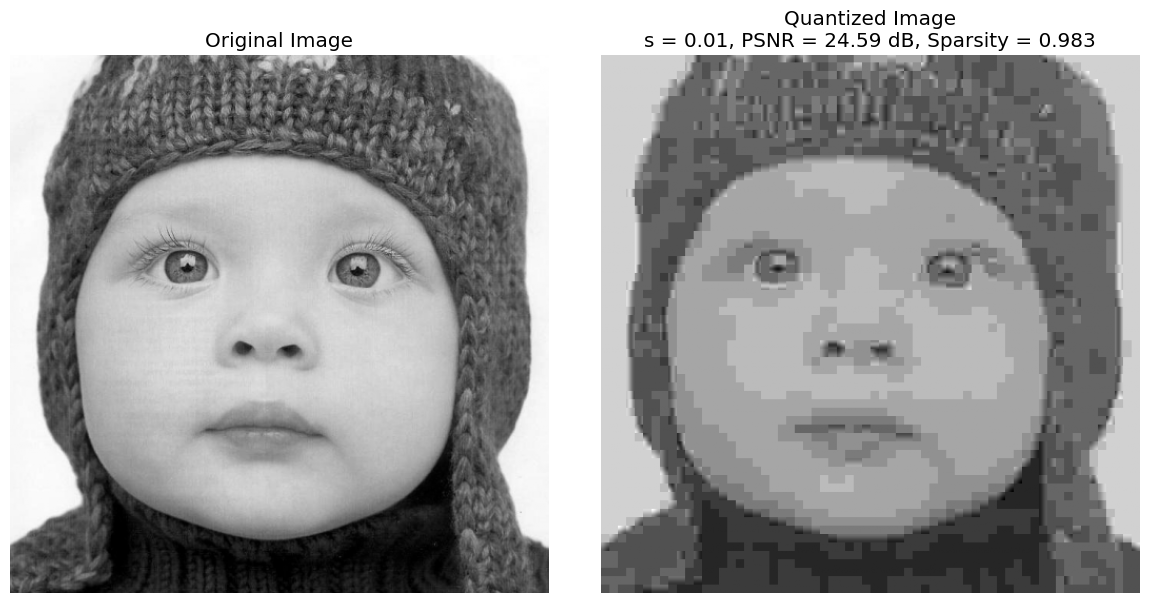

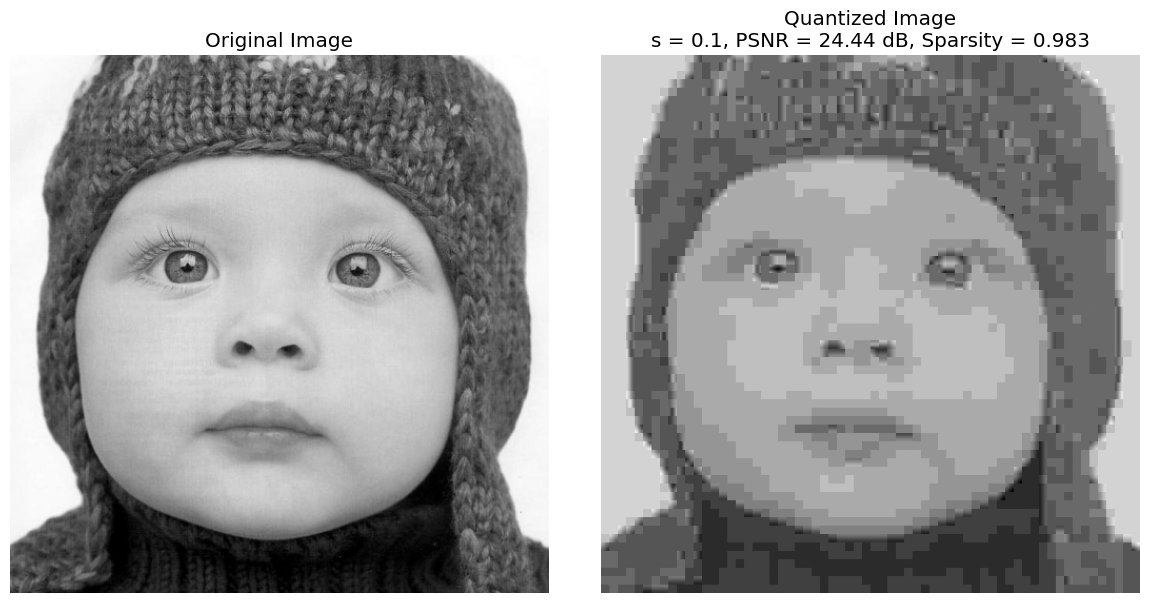

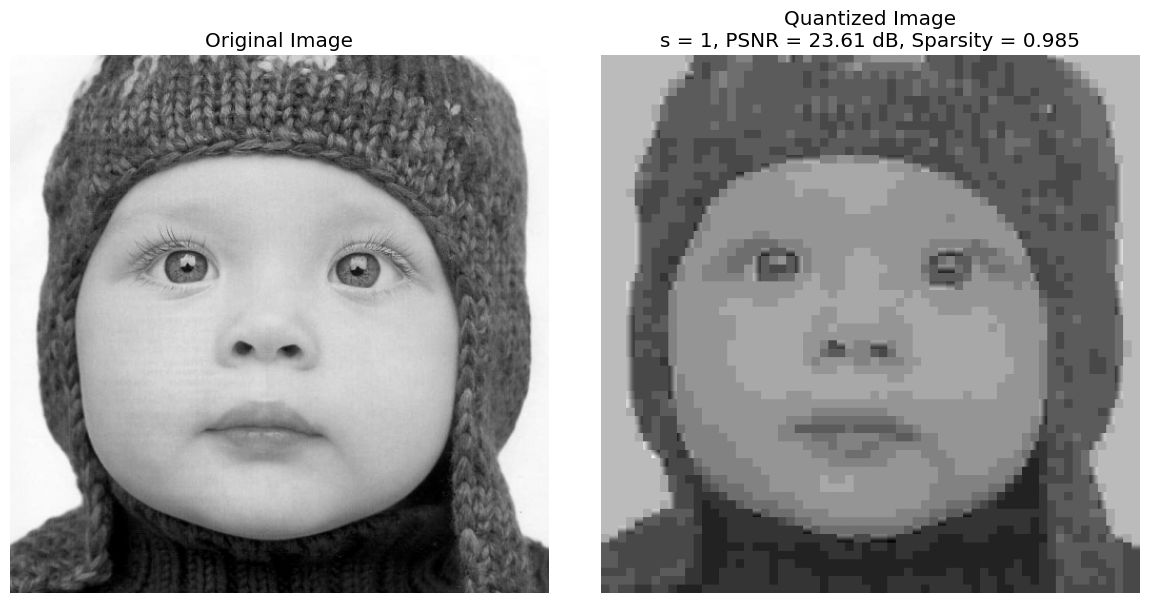

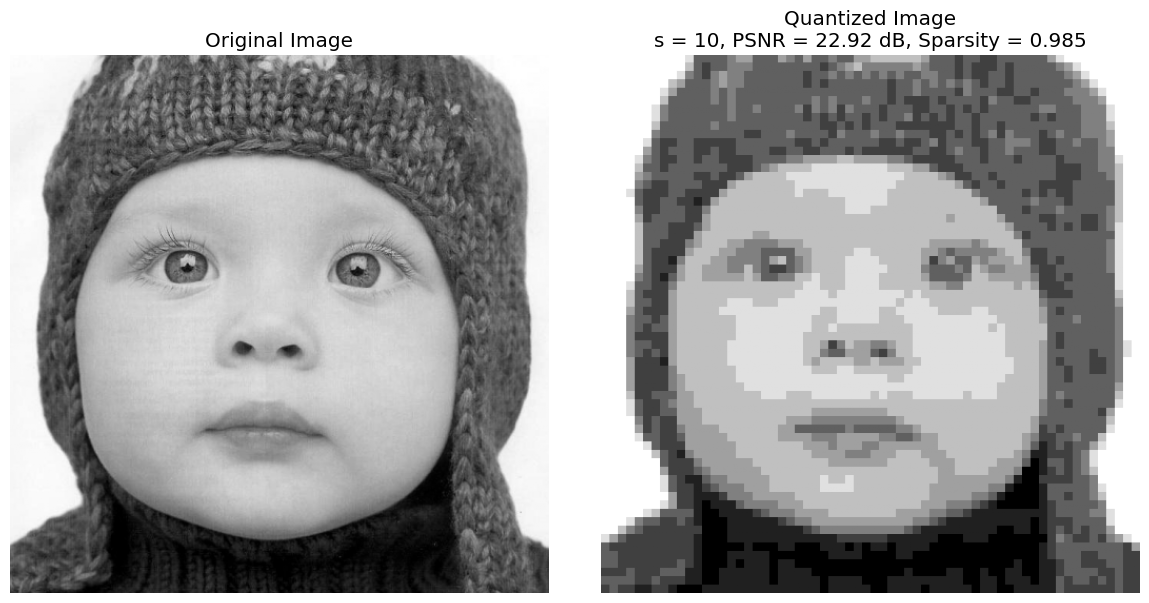

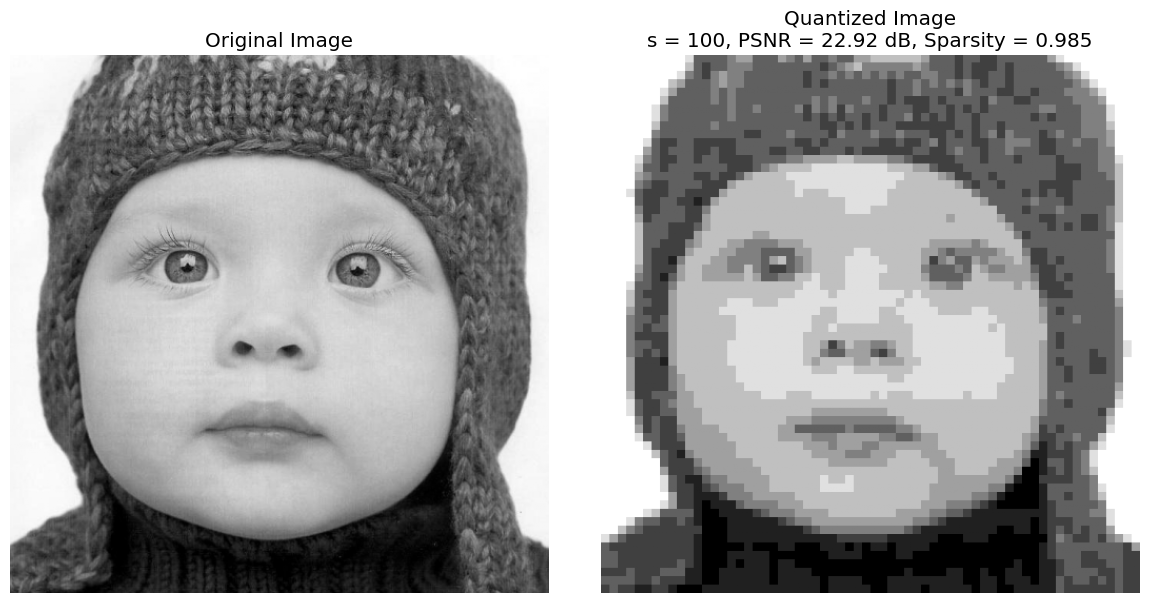

In [ ]:
# Loop over different compression strengths
s_values = [0.01, 0.1, 1, 10, 100]

# Store results
results = {
    's': [],
    'psnr': [],
    'sparsity': [] 
}

# Create a figure for each s value showing original and quantized image side by side
for s in s_values:
    u, v = np.meshgrid(np.arange(0, block_size), np.arange(0, block_size))
    Q = 1 + s * (u + v)
    
    quantized_dct_blocks = np.round(dct_blocks / Q)
    
    dequantized_dct_blocks = quantized_dct_blocks * Q
    
    reconstructed_quantized_image = np.zeros_like(baby_image)
    for i in range(dct_blocks.shape[0]):
        for j in range(dct_blocks.shape[1]):
            dct_block = dequantized_dct_blocks[i, j]
            block = D.T @ dct_block @ D
            reconstructed_quantized_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block
    
    # Calculate PSNR
    mse = np.mean((baby_image - reconstructed_quantized_image)**2)
    psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')
    
    # Calculate sparsity (fraction of zero coefficients after quantization)
    total_coeffs = quantized_dct_blocks.size
    zero_coeffs = np.sum(quantized_dct_blocks == 0)
    sparsity = zero_coeffs / total_coeffs
    
    # Store results
    results['s'].append(s)
    results['psnr'].append(psnr)
    results['sparsity'].append(sparsity)
    
    # Display original and quantized images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(baby_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed_quantized_image, cmap='gray')
    axes[1].set_title(f'Quantized Image\ns = {s}, PSNR = {psnr:.2f} dB, Sparsity = {sparsity:.3f}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

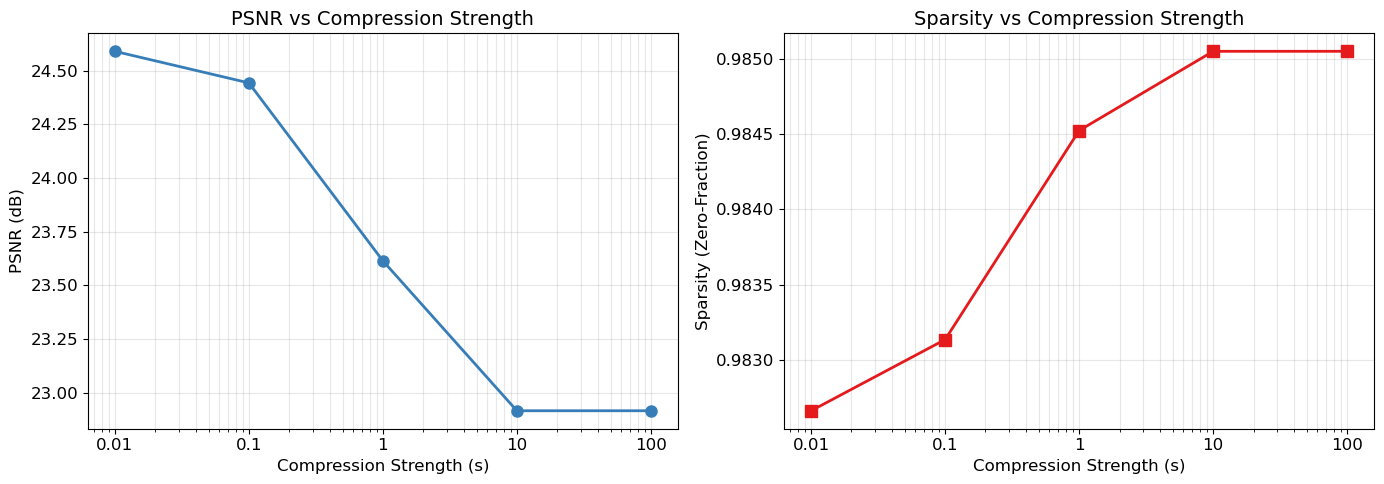

In [21]:
# Plot PSNR and Sparsity vs Compression Strength
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: PSNR vs Compression Strength
axes[0].plot(results['s'], results['psnr'], marker='o', linewidth=2, markersize=8, color=colors["blue"])
axes[0].set_xscale('log')
axes[0].set_xlabel('Compression Strength (s)', fontsize=12)
axes[0].set_ylabel('PSNR (dB)', fontsize=12)
axes[0].set_title('PSNR vs Compression Strength', fontsize=14)
axes[0].grid(True, which="both", ls="-", alpha=0.3)
axes[0].set_xticks(results['s'])
axes[0].set_xticklabels([str(s) for s in results['s']])

# Plot 2: Sparsity vs Compression Strength  
axes[1].plot(results['s'], results['sparsity'], marker='s', linewidth=2, markersize=8, color=colors["red"])
axes[1].set_xscale('log')
axes[1].set_xlabel('Compression Strength (s)', fontsize=12)
axes[1].set_ylabel('Sparsity (Zero-Fraction)', fontsize=12)
axes[1].set_title('Sparsity vs Compression Strength', fontsize=14)
axes[1].grid(True, which="both", ls="-", alpha=0.3)
axes[1].set_xticks(results['s'])
axes[1].set_xticklabels([str(s) for s in results['s']])

plt.tight_layout()
plt.show()

#### Part 3(e): Energy compaction (core concept)

In [25]:
# Energy compaction analysis
# For each block, compute E_total and E_K for different K values

K_values = np.arange(1, 9)  # K = 1, 2, ..., 8
energy_fractions_low_freq = []
energy_fractions_high_freq = []

# Loop over all blocks
num_blocks_h = dct_blocks.shape[0]
num_blocks_w = dct_blocks.shape[1]

for K in K_values:
    low_freq_ratios = []
    high_freq_ratios = []
    
    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            # Get the DCT block
            x_uv = dct_blocks[i, j]
            
            # Compute total energy
            E_total = np.sum(np.abs(x_uv)**2)
            
            # a) Low-frequency square (top-left K x K)
            E_K_low = np.sum(np.abs(x_uv[:K, :K])**2)
            
            # c) High-frequency square (bottom-right K x K)
            E_K_high = np.sum(np.abs(x_uv[-K:, -K:])**2)
            
            # Calculate energy fractions
            if E_total > 0:
                low_freq_ratios.append(E_K_low / E_total)
                high_freq_ratios.append(E_K_high / E_total)
    
    # Average over all blocks
    energy_fractions_low_freq.append(np.mean(low_freq_ratios))
    energy_fractions_high_freq.append(np.mean(high_freq_ratios))

print("Low-frequency (top-left K x K) energy fractions:")
for K, energy_frac in zip(K_values, energy_fractions_low_freq):
    print(f"K = {K}: E_K / E_total = {energy_frac:.4f}")

print("\nHigh-frequency (bottom-right K x K) energy fractions:")
for K, energy_frac in zip(K_values, energy_fractions_high_freq):
    print(f"K = {K}: E_K / E_total = {energy_frac:.4f}")

Low-frequency (top-left K x K) energy fractions:
K = 1: E_K / E_total = 0.9584
K = 2: E_K / E_total = 0.9824
K = 3: E_K / E_total = 0.9917
K = 4: E_K / E_total = 0.9952
K = 5: E_K / E_total = 0.9974
K = 6: E_K / E_total = 0.9987
K = 7: E_K / E_total = 0.9995
K = 8: E_K / E_total = 1.0000

High-frequency (bottom-right K x K) energy fractions:
K = 1: E_K / E_total = 0.0000
K = 2: E_K / E_total = 0.0000
K = 3: E_K / E_total = 0.0001
K = 4: E_K / E_total = 0.0004
K = 5: E_K / E_total = 0.0012
K = 6: E_K / E_total = 0.0032
K = 7: E_K / E_total = 0.0110
K = 8: E_K / E_total = 1.0000


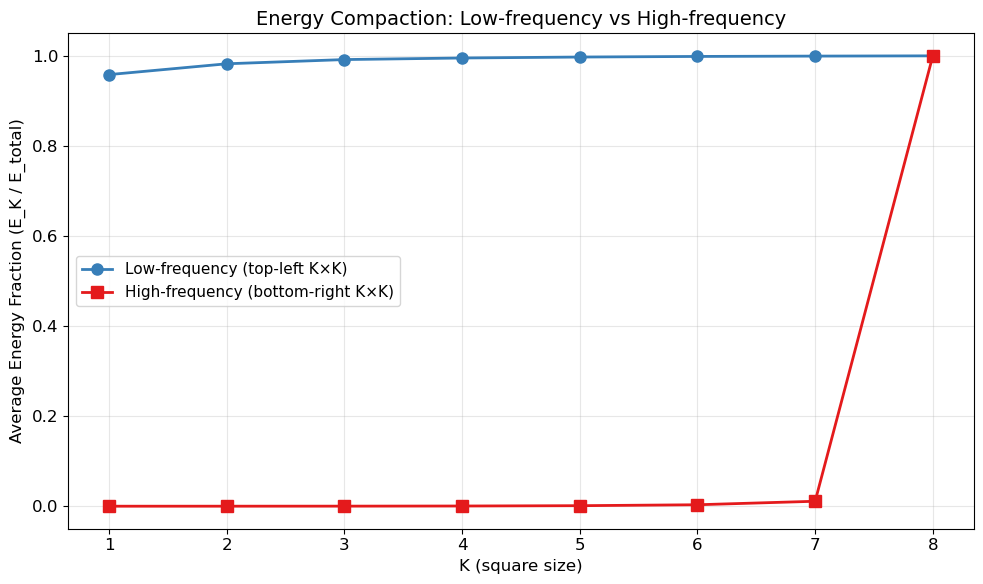

In [26]:
# Plot energy fraction vs K for both low-frequency and high-frequency
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(K_values, energy_fractions_low_freq, marker='o', linewidth=2, markersize=8, 
        color=colors["blue"], label='Low-frequency (top-left K×K)')
ax.plot(K_values, energy_fractions_high_freq, marker='s', linewidth=2, markersize=8, 
        color=colors["red"], label='High-frequency (bottom-right K×K)')

ax.set_xlabel('K (square size)', fontsize=12)
ax.set_ylabel('Average Energy Fraction (E_K / E_total)', fontsize=12)
ax.set_title('Energy Compaction: Low-frequency vs High-frequency', fontsize=14)
ax.set_xticks(K_values)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()